In [0]:
fileroot = "clinicaltrial_2023"
pharma = "pharma"

dbutils.fs.head("/FileStore/tables/" + fileroot + ".csv")

[Truncated to first 65536 bytes]


'"Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,\r\n"NCT03630471\tEffectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India\tPRIDE\tCOMPLETED\tMental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)\tBEHAVIORAL: PRIDE \'Step 1\' problem-solving intervention|BEHAVIORAL: Enhanced usual care\tSangath\tHarvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine\t250.0\tOTHER\tINTERVENTIONAL\tAllocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT\t2018-08-20\t2019-02-28",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

# A dictionary to store different delimiters for each clinical trial file
delimiter_selector = {
    "clinicaltrial_2023": "\t",
    "clinicaltrial_2021": "|",
    "clinicaltrial_2020": "|",
    "pharma": ","
}

# Function to create a DataFrame
def create_dataframe(clinicaltrial_2023):
    # If the clinical trial is 2023
    if clinicaltrial_2023 == "clinicaltrial_2023":
        # Read the data file as an RDD, split rows by delimiter, and handle column mismatches
        rdd = sc.textFile(f"/FileStore/tables/{clinicaltrial_2023}.csv").map(lambda row: row.split(delimiter_selector[clinicaltrial_2023]))
        head = rdd.first() # Extract header
        # Ensure each row has the same number of columns as the header
        rdd = rdd.map(lambda row: row + [" " for i in range(len(head) - len(row))] if len(row) < len(head) else row )
        # Convert RDD to DataFrame
        df = rdd.toDF()
        first = df.first() # Extract first row
        # Rename columns with "_<index>" to their corresponding names from the first row
        for col in range(0, len(list(first))):
           df = df.withColumnRenamed(f"_{col + 1}", list(first)[col])
        # Add an index column to the DataFrame
        df = df.withColumn('index', monotonically_increasing_id())
        # Filter out the first row (header) and drop the index column
        return df.filter(~df.index.isin([0])).drop('index')
    # For other clinical trial years, assuming CSV files with headers
    else:
        # Read the CSV file directly into a DataFrame using Spark SQL
        return spark.read.csv(f"/FileStore/tables/{clinicaltrial_2023}.csv", sep=delimiter_selector[clinicaltrial_2023], header=True)

# Call the function to create the DataFrame for the specified clinical trial
clinical_dataframe = create_dataframe("clinicaltrial_2023")

# Show the first 20 rows of the DataFrame
clinical_dataframe.show(20)

+------------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|         "Id|         Study Title|   Acronym|            Status|          Conditions|       Interventions|             Sponsor|       Collaborators|Enrollment|Funder Type|          Type|        Study Design|     Start|Completion",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,|
+------------+--------------------+----------+------------------+--------------------+--------------------+---------

In [0]:
# QUESTION 1: NUMBER OF STUDIES IN THE DATASET

# Count the number of distinct rows in the DataFrame, effectively counting the number of unique rows.
clinical_dataframe.distinct().count()


483422

In [0]:
# QUESTION TWO: ALL TYPES OF TRIALS & THEIR FREQUENCY
clinical_dataframe.groupBy('Type').count().orderBy('count', ascending=False).show(3)

+---------------+------+
|           Type| count|
+---------------+------+
| INTERVENTIONAL|371382|
|  OBSERVATIONAL|110221|
|EXPANDED_ACCESS|   928|
+---------------+------+
only showing top 3 rows



In [0]:
# QUESTION 3: TOP 5 CONDITIONS WITH THEIR FREQUENCIES

from pyspark.sql.functions import split, explode, trim, col

# Define delimiter for the Conditions column based on the clinical trial data
conditions_delimiter = {
    "clinicaltrial_2023": "\t",
    "clinicaltrial_2021": ",",
    "clinicaltrial_2020": ",",
}

# Split the Conditions column based on the delimiter for the specific clinical trial data
split_conditions_df = clinical_dataframe \
    .withColumn('Conditions', explode(split(trim(col('Conditions')), conditions_delimiter[fileroot])))

# Group by Conditions, count occurrences, and filter out empty values
result_df = split_conditions_df \
    .groupBy('Conditions') \
    .count() \
    .orderBy('count', ascending=False) \
    .filter("Conditions != ''")

# Show top 5 results
result_df.show(5, truncate=False)

+---------------+-----+
|Conditions     |count|
+---------------+-----+
|Healthy        |7997 |
|Breast Cancer  |4556 |
|Prostate Cancer|2650 |
|Asthma         |2309 |
|Obesity        |2284 |
+---------------+-----+
only showing top 5 rows



In [0]:
# QUESTION 4: RETRIEVE THE TOP 10 SPONSORS THAT ARE NOT PHARMACEUTICAL COMPANIES  
pharma_list = create_dataframe(pharma).select("Parent_Company").rdd.flatMap(lambda x: x).collect()
clinical_sponsor_dataframe = clinical_dataframe.select("Sponsor")

non_pharma_sponsors = clinical_sponsor_dataframe.groupBy("Sponsor").count().orderBy("count", ascending=False).filter(~clinical_sponsor_dataframe.Sponsor.isin(pharma_list)).show(10)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3410|
|   Assiut University| 3335|
|    Cairo University| 3023|
|Assistance Publiq...| 2951|
|         Mayo Clinic| 2766|
|M.D. Anderson Can...| 2702|
|Novartis Pharmace...| 2393|
|National Institut...| 2340|
|Massachusetts Gen...| 2263|
|National Taiwan U...| 2181|
+--------------------+-----+
only showing top 10 rows



In [0]:
# Question 5:PLOTTING THE NUMBER OF COMPLETED STUDIES EACH MONTH IN A GIVEN YEAR

from pyspark.sql.functions import split, regexp_replace, when

# Rename columns to remove any leading or trailing commas and quotes
for col in clinical_dataframe.columns:
    clinical_dataframe = clinical_dataframe.withColumnRenamed(col, col.strip(",").strip('"'))

# Define a dictionary to map numerical month values to month names
month_names = {
    "01": "January", "02": "February", "03": "March", "04": "April", "05": "May", "06": "June",
    "07": "July", "08": "August", "09": "September", "10": "October", "11": "November", "12": "December"
}

# Extract year and month from the 'Completion' column and clean month format
completed_cd = clinical_dataframe \
    .withColumn('Year', split('Completion', "-")[0]) \
    .withColumn('Month', split('Completion', "-")[1]) \
    .withColumn('Month', regexp_replace("Month", ",", "")) \
    .withColumn('Month', regexp_replace("Month", '"', "")) \
    .filter(clinical_dataframe.Status.isin(["COMPLETED"])) \
    .select("Month", "Year", "Status")

# Filter for the year 2023 and group by month
completed_cd_2023 = completed_cd.filter(completed_cd.Year.isin(["2023"])) \
    .groupBy("Month").count().orderBy("Month", ascending=True)

# Map numerical month values to month names
completed_cd_2023 = completed_cd_2023.withColumn("Month", 
                                                 when(completed_cd_2023["Month"] == "01", "January")
                                                 .when(completed_cd_2023["Month"] == "02", "February")
                                                 .when(completed_cd_2023["Month"] == "03", "March")
                                                 .when(completed_cd_2023["Month"] == "04", "April")
                                                 .when(completed_cd_2023["Month"] == "05", "May")
                                                 .when(completed_cd_2023["Month"] == "06", "June")
                                                 .when(completed_cd_2023["Month"] == "07", "July")
                                                 .when(completed_cd_2023["Month"] == "08", "August")
                                                 .when(completed_cd_2023["Month"] == "09", "September")
                                                 .when(completed_cd_2023["Month"] == "10", "October")
                                                 .when(completed_cd_2023["Month"] == "11", "November")
                                                 .when(completed_cd_2023["Month"] == "12", "December"))

# Show the result
completed_cd_2023.show()

+---------+-----+
|    Month|count|
+---------+-----+
|  January| 1494|
| February| 1272|
|    March| 1552|
|    April| 1324|
|      May| 1415|
|     June| 1619|
|     July| 1360|
|   August| 1230|
|September| 1152|
|  October| 1058|
| November|  909|
| December| 1082|
+---------+-----+



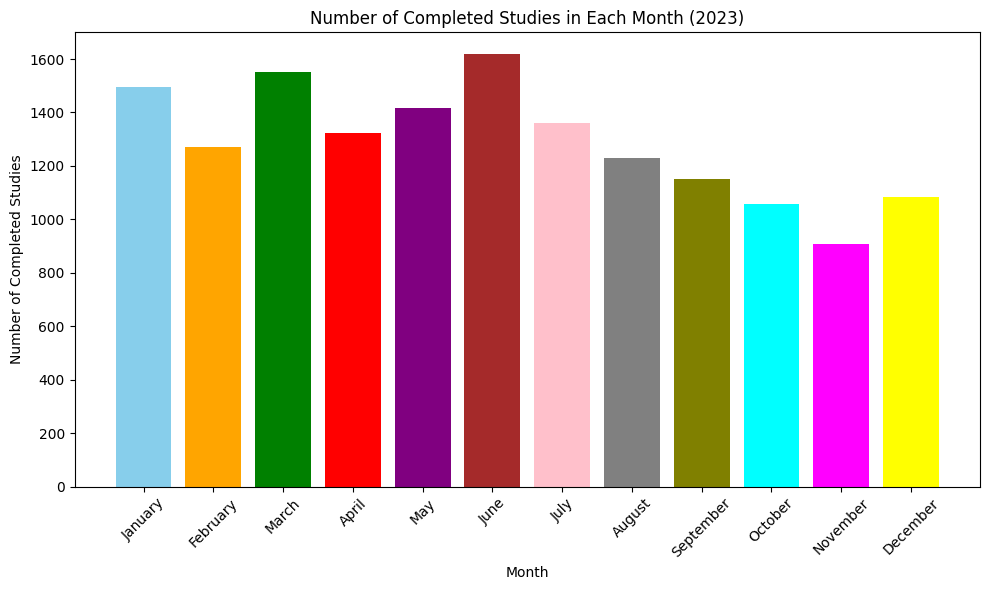

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming completed_cd_2023 is the DataFrame containing the result
result_df = completed_cd_2023.toPandas()

# Define a list of colors for each bar
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']

# Plotting the bar chart with different colors
plt.figure(figsize=(10, 6))
plt.bar(result_df['Month'], result_df['count'], color=colors)

# Add title and labels
plt.title('Number of Completed Studies in Each Month (2023)')
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


# FURTHER ANALYSIS  

In [0]:
# QUESTION 7: Companies that are pharmaceutical companies
from pyspark.sql.functions import col

# Retrieve the list of pharmaceutical companies
pharma_list = create_dataframe(pharma).select("Parent_Company").rdd.flatMap(lambda x: x).collect()

# Filter out pharmaceutical companies from the clinical trial sponsors
pharma_sponsors = clinical_dataframe.select("Sponsor").groupBy("Sponsor").count().filter(col("Sponsor").isin(pharma_list)).orderBy("count", ascending=False).limit(10)

# Show the top 10 pharmaceutical sponsors
pharma_sponsors.show()


+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|     GlaxoSmithKline| 3482|
|              Pfizer| 3045|
|         AstraZeneca| 3024|
|Boehringer Ingelheim| 2146|
|              Sanofi| 1404|
|Bristol-Myers Squibb| 1383|
|               Amgen|  851|
|              AbbVie|  728|
|            Novartis|  697|
|     Gilead Sciences|  625|
+--------------------+-----+

